In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K

<h2 align='center'> Load data </h2>

In [13]:
data = pd.read_excel(r'C:\Users\glebf\OneDrive\Рабочий стол\Lithium.xlsx')
temperature = np.array(data['T'])
pressure = np.array(data['p'])
density = np.array(data['rho'])

MIN_TEMPERATURE = min(temperature)
MAX_TEMPERATURE = max(temperature)
MIN_PRESSURE = min(pressure)
MAX_PRESSURE = max(pressure)
MIN_DENSITY = min(density)
MAX_DENSITY = max(density)

linearized_temperature = (temperature - MIN_TEMPERATURE) / (MAX_TEMPERATURE - MIN_TEMPERATURE)
linearized_pressure = (pressure - MIN_PRESSURE) / (MAX_PRESSURE - MIN_PRESSURE)
linearized_density = (density - MIN_DENSITY) / (MAX_DENSITY - MIN_DENSITY)

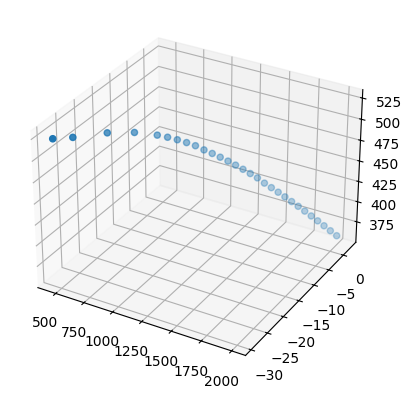

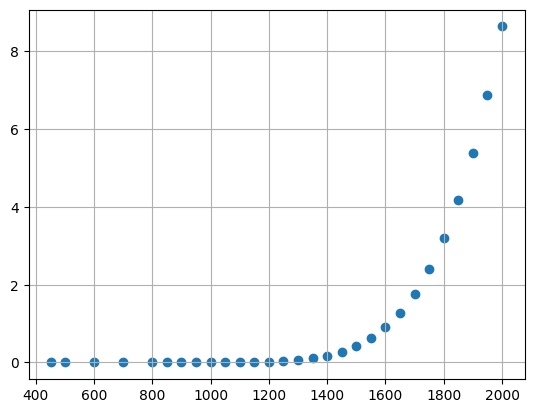

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(temperature, np.log(pressure), density)
plt.show()

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(temperature, pressure)
ax.grid(True)
plt.show()

<h2 align='center'> RBF Network </h2>

In [2]:
class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)
        
    def build(self, __input_shape):
        self.mu = self.add_weight(
            name='mu',
            shape=(int(__input_shape[1]), self.units),
            initializer='uniform',
            trainable=True
        )
        super(RBFLayer, self).build(__input_shape)
        
    def call(self, __inputs):
        diff = K.expand_dims(__inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-self.gamma * l2)
        return res
    
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units
        

In [3]:
from keras.layers import Dense, Flatten, Input
from keras.models import Sequential
from keras.losses import binary_crossentropy

model = Sequential()
model.add(Input(shape=(1,)))
model.add(RBFLayer(20, 0.5))
model.add(RBFLayer(20, 0.5))
model.add(Dense(2, activation='sigmoid', name='foo'))
model.compile(optimizer='rmsprop', loss=binary_crossentropy)

In [4]:
x_train = np.array([linearized_temperature]).T
y_train = np.array([linearized_pressure, linearized_density]).T

model.fit(x_train, y_train, epochs=2000, verbose=0)

NameError: name 'linearized_temperature' is not defined

32/32 [==============================] - 0s 1ms/step


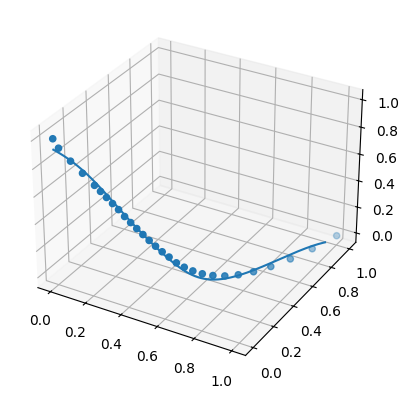

In [93]:
x_validate = np.linspace(0, 1, 1000)
y_validate = model.predict(x_validate).T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(linearized_temperature, linearized_pressure, linearized_density)
ax.plot(x_validate, y_validate[0], y_validate[1])
plt.show()

<h2 align='center'> Standart network </h2>

In [94]:
inputs = tf.keras.layers.Input(shape=(1,))
x = tf.keras.layers.Dense(20, activation='tanh')(inputs)
x = tf.keras.layers.Dense(20, activation='tanh')(x)
outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='rmsprop', loss=binary_crossentropy, metrics=['accuracy'])

In [95]:
x_train = np.array([linearized_temperature]).T
y_train = np.array([linearized_pressure, linearized_density]).T

model.fit(x_train, y_train, epochs=2000, verbose=0)

32/32 [==============================] - 0s 1ms/step


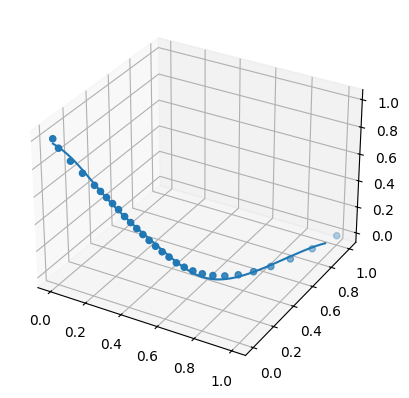

In [96]:
x_validate = np.linspace(0, 1, 1000)
y_validate = model.predict(x_validate).T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(linearized_temperature, linearized_pressure, linearized_density)
ax.plot(x_validate, y_validate[0], y_validate[1])
plt.show()

In [5]:
import requests

data = requests.get('http://77.246.98.155/database/phase_diagram/?format=json').json()
temperature = np.array([dat['temperature'] for dat in data if dat['temperature']])
pressure = np.array([dat['pressure'] for dat in data if dat['temperature']])
density = np.array([dat['density'] for dat in data if dat['temperature']])

linearized_temperature = (temperature - min(temperature)) / (max(temperature) - min(temperature))
linearized_pressure = (pressure - min(pressure)) / (max(pressure) - min(pressure))
linearized_density = (density - min(density)) / (max(density) - min(density))


data = requests.get('http://77.246.98.155/database/saturation/?format=json').json()
saturation_temperature = np.array([dat['temperature'] for dat in data if dat['temperature']])
saturation_pressure = np.array([dat['pressure'] for dat in data if dat['temperature']])
saturation_density = np.array([dat['density'] for dat in data if dat['temperature']])

linearized_saturation_temperature = (saturation_temperature - min(saturation_temperature)) / (max(saturation_temperature) - min(saturation_temperature))
linearized_saturation_pressure = (saturation_pressure - min(saturation_pressure)) / (max(saturation_pressure) - min(saturation_pressure))
linearized_saturation_density = (saturation_density - min(saturation_density)) / (max(saturation_density) - min(saturation_density))

In [71]:
from tensorflow.keras.optimizers import Adam

inputs = tf.keras.layers.Input(shape=(2,))
x = tf.keras.layers.Dense(10, activation='gelu')(inputs)
x = tf.keras.layers.Dense(10, activation='gelu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model1 = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])
model1.summary()

model2 = Sequential(name='Model')
model2.add(Input(shape=(2,)))
model2.add(Dense(20, activation='relu', name='foo1'))
# model2.add(RBFLayer(20, 0.7))
model2.add(Dense(20, activation='gelu', name='foo2'))
model2.add(Dense(1, activation='linear', name='foo3'))
model2.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
model2.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_82 (Dense)            (None, 10)                30        
                                                                 
 dense_83 (Dense)            (None, 10)                110       
                                                                 
 dense_84 (Dense)            (None, 1)                 11        
                                                                 
Total params: 151 (604.00 Byte)
Trainable params: 151 (604.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 foo1

In [74]:
index = np.arange(len(temperature))
np.random.shuffle(index)

x_train = np.array([linearized_temperature[index], linearized_pressure[index]]).T
y_train = np.array([linearized_density[index]]).T
lls = model2.fit(x_train, y_train, epochs=500, use_multiprocessing=True, validation_split=0.2)

Epoch 1/500
21/21 [==============================] - 0s 6ms/step - loss: 8.2295e-05 - val_loss: 9.0797e-05
Epoch 2/500
21/21 [==============================] - 0s 4ms/step - loss: 8.1313e-05 - val_loss: 9.1513e-05
Epoch 3/500
21/21 [==============================] - 0s 5ms/step - loss: 8.1151e-05 - val_loss: 9.3116e-05
Epoch 4/500
21/21 [==============================] - 0s 4ms/step - loss: 8.1122e-05 - val_loss: 9.4825e-05
Epoch 5/500
21/21 [==============================] - 0s 4ms/step - loss: 8.0194e-05 - val_loss: 9.2774e-05
Epoch 6/500
21/21 [==============================] - 0s 3ms/step - loss: 8.1487e-05 - val_loss: 9.2479e-05
Epoch 7/500
21/21 [==============================] - 0s 3ms/step - loss: 8.1597e-05 - val_loss: 9.2222e-05
Epoch 8/500
21/21 [==============================] - 0s 3ms/step - loss: 7.9689e-05 - val_loss: 9.3986e-05
Epoch 9/500
21/21 [==============================] - 0s 3ms/step - loss: 8.1289e-05 - val_loss: 9.4025e-05
Epoch 10/500
21/21 [=================

27/27 [==============================] - 0s 1ms/step


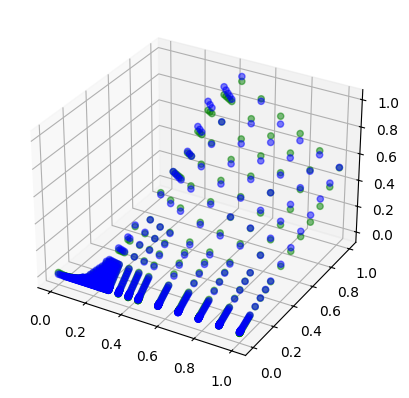

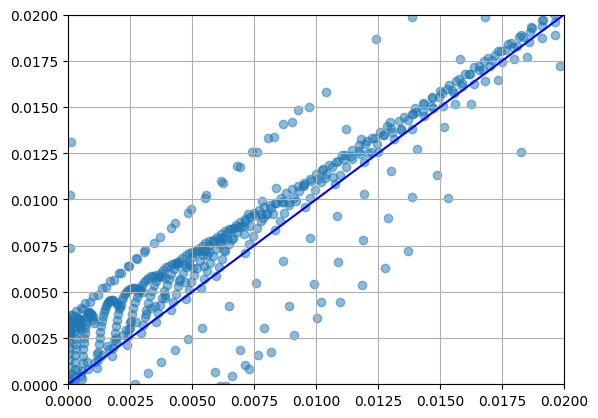

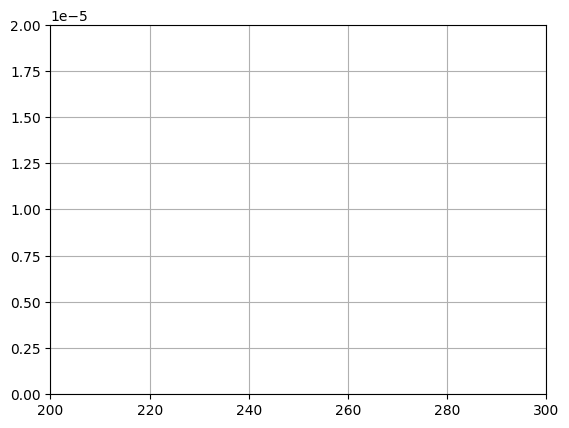

In [73]:
x_test = np.array([linearized_temperature[index], linearized_pressure[index]]).T
# y_test1 = model1.predict(x_test).T
y_test2 = model2.predict(x_test).T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(linearized_temperature, linearized_pressure, y_test1, color='r', alpha=0.5)
ax.scatter(linearized_temperature[index], linearized_pressure[index], y_test2, color='g', alpha=0.5)
ax.scatter(linearized_temperature[index], linearized_pressure[index], linearized_density[index], color='b', alpha=0.5)
plt.show()


linear_x = np.linspace(0, 1, 100)
linear_y = linear_x

fig = plt.figure()
plt.scatter(linearized_density[index], y_test2, alpha=0.5)
plt.plot(linear_x, linear_y, 'b-')
plt.xlim([0, 0.02])
plt.ylim([0, 0.02])
plt.grid(True)
plt.show()

loss = lls.history['loss']
fig = plt.figure()
plt.plot(range(0, len(loss)), loss)
plt.xlim([200, 300])
plt.ylim([0, 2e-5])
plt.grid(True)
plt.show()

In [15]:
data = pd.read_excel(r'C:\Users\glebf\OneDrive\Рабочий стол\Lithium_phase.xlsx')
temperature = np.array(data['T'])
pressure = np.array(data['P'])
density = np.array(data['D'])

MIN_TEMPERATURE = min(temperature)
MAX_TEMPERATURE = max(temperature)
MIN_PRESSURE = min(pressure)
MAX_PRESSURE = max(pressure)
MIN_DENSITY = min(density)
MAX_DENSITY = max(density)

linearized_temperature = (temperature - MIN_TEMPERATURE) / (MAX_TEMPERATURE - MIN_TEMPERATURE)
linearized_pressure = (pressure - MIN_PRESSURE) / (MAX_PRESSURE - MIN_PRESSURE)
linearized_density = (density - MIN_DENSITY) / (MAX_DENSITY - MIN_DENSITY)

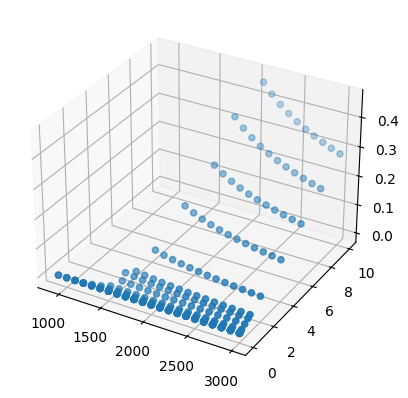

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(temperature, pressure, density)
plt.show()

In [68]:
from keras.layers import Dense, Flatten, Input
from keras.models import Sequential
from keras.losses import binary_crossentropy

model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='Adam', loss='mse')
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 50)                150       
                                                                 
 dense_47 (Dense)            (None, 1)                 51        
                                                                 
Total params: 201 (804.00 Byte)
Trainable params: 201 (804.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
index = np.arange(len(temperature))
np.random.shuffle(index)

x_train = np.array([linearized_temperature[index], linearized_pressure[index]]).T
y_train = np.array([linearized_density[index]]).T
lls = model.fit(x_train, y_train, epochs=200, use_multiprocessing=True, validation_split=0.3, batch_size=8)

Epoch 1/200
26/26 [==============================] - 2s 16ms/step - loss: 0.0180 - val_loss: 0.0092
Epoch 2/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0029
Epoch 3/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 4/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 5/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/200
26/26 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/200
26/26 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/200
26/26 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 11

10/10 [==============================] - 0s 2ms/step


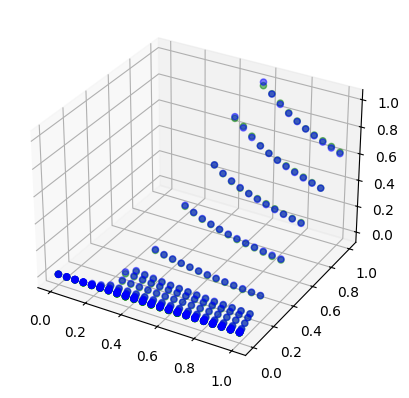

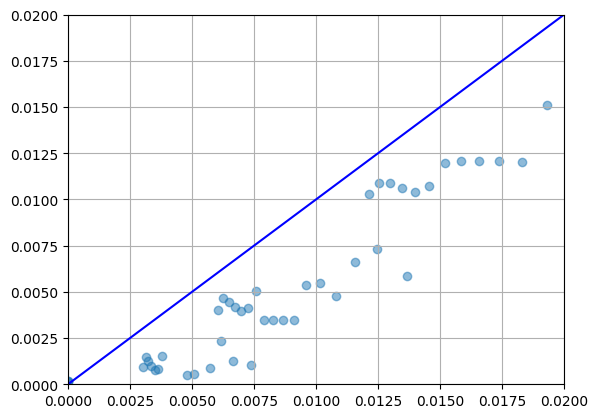

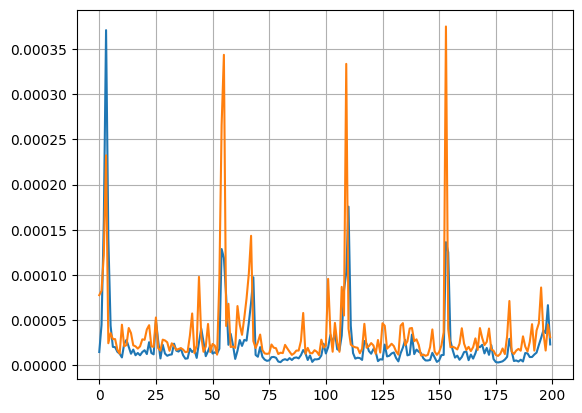

In [67]:
x_test = np.array([linearized_temperature[index], linearized_pressure[index]]).T
y_test = model.predict(x_test).T

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(linearized_temperature[index], linearized_pressure[index], y_test, color='g', alpha=0.5)
ax.scatter(linearized_temperature[index], linearized_pressure[index], linearized_density[index], color='b', alpha=0.5)
plt.show()


linear_x = np.linspace(0, 1, 100)
linear_y = linear_x

fig = plt.figure()
plt.scatter(linearized_density[index], y_test, alpha=0.5)
plt.plot(linear_x, linear_y, 'b-')
plt.xlim([0, 0.02])
plt.ylim([0, 0.02])
plt.grid(True)
plt.show()

loss = lls.history['loss']
val_loss = lls.history['val_loss']
fig = plt.figure()
plt.plot(range(0, len(loss)), loss)
plt.plot(range(0, len(val_loss)), val_loss)
# plt.xlim([200, 300])
# plt.ylim([0, 2e-5])
plt.grid(True)
plt.show()